# 5 Modeling

## 5.1 Data Source

In [ ]:
#using GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug  1 21:56:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# packages for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# packages required to calculate jaccard similarity
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

# Normalizing data
from sklearn.preprocessing import Normalizer

# regex
import re

# importing non-negative matrix factorization
from sklearn.decomposition import NMF


In [ ]:
# function to find similar movies and provide recommendation
def similar_movies(x, data, k=None):
    """The function take a movie and returns [k:optional] similar movies"""
    # if data.index.any(x) == False:
    #     return print('The movie is not in the database')
    
    movies=data.loc[x]
    
    if k == None:        
        movies_rec=movies.sort_values(ascending=False)
    else: 
        movies_rec=movies.sort_values(ascending=False)[0:k]
        
    return movies_rec

In [ ]:
def outlier_detect(colname, df):
    """outlier detection is based on 1.5 times the iqr. The function looks at each value an determines if
    it is a potential outlier. Make sure to create a new column caller 'outlier' in df before applying 
    this function.
    
    outlier_detect(colname, df)
    where colname is the column name and df is the dataframe you are interested in"""
    
    
    percent25=df[colname].quantile(.25)
    percent75=df[colname].quantile(.75)
    iqr=percent75 - percent25
    
    upper=percent75 + 1.5*iqr
    lower=percent25 - 1.5*iqr
    
    return lower, upper

## 5.2 Collabrative Based Recommendation System

### 5.2.1 Importing Data

In [ ]:
# collecting ratings data
ratings=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/ratings_cleaned.csv')

In [ ]:
# collecting movie data
metadata=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movies_metadata_small.csv')

In [ ]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,userId,movieId,rating
0,0,0,1,110,1.0
1,1,1,1,147,4.5
2,2,2,1,858,5.0
3,3,3,1,1221,5.0
4,4,4,1,1246,5.0


In [ ]:
metadata.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,imdb_id,original_language,overview,release_date,spoken_languages,title,...,Mystery,War,Foreign,Music,Documentary,Western,production_companies_list,spoken_languages_list,release_year,outlier
0,0,0,0,862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,...,0,0,0,0,0,0,['Pixar Animation Studios'],['en'],1995,non-outlier
1,1,1,1,8844,tt0113497,en,When siblings Judy and Peter discover an encha...,1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,...,0,0,0,0,0,0,"['TriStar Pictures', 'Teitler Film', 'Intersco...","['en', 'fr']",1995,non-outlier
2,2,2,2,15602,tt0113228,en,A family wedding reignites the ancient feud be...,1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,...,0,0,0,0,0,0,"['Warner Bros.', 'Lancaster Gate']",['en'],1995,non-outlier
3,3,3,3,31357,tt0114885,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,...,0,0,0,0,0,0,['Twentieth Century Fox Film Corporation'],['en'],1995,non-outlier
4,4,4,4,11862,tt0113041,en,Just when George Banks has recovered from his ...,1995-02-10,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,...,0,0,0,0,0,0,"['Sandollar Productions', 'Touchstone Pictures']",['en'],1995,non-outlier


### 5.2.2 Formatting

#### 5.2.2.1 Formatting Movie Data

I am creating a user movie rating matrix. For collaborative filtering, I won't use any of the movie metadata; however, I am using the metadata to get the movie titles used in the ratings dataset.

In [ ]:
# selecting only movie id and title
movies=metadata[['id','title']]
movies.head()

,id,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
# deleting metadata
del metadata

In [ ]:
# find the total number of movies
movies.shape

(21740, 2)

In [ ]:
# checking data types
movies.dtypes

id        int64
title    object
dtype: object

In [ ]:
# convert id to string
movies['id']=movies['id'].astype(str)

# making sure it worked
movies.dtypes

id       object
title    object
dtype: object

In [ ]:
# checking for unique values
movies['id'].unique()

array(['862', '8844', '15602', ..., '49280', '404604', '30840'],
      dtype=object)

all movie id's appear to be unique. Next, I will check for missing values. Since missing values may be encoded as empty quotes, I will check to see if there are any entries that are empty quotes.

In [ ]:
movies['id'].isna().any()

False

In [ ]:
movies[movies['id']=='']

,id,title


#### 5.2.2.2 Formating Ratings data

In [ ]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,userId,movieId,rating
0,0,0,1,110,1.0
1,1,1,1,147,4.5
2,2,2,1,858,5.0
3,3,3,1,1221,5.0
4,4,4,1,1246,5.0


In [ ]:
# Need to remove the two unnamed columns
ratings.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [ ]:
ratings.shape

(26024289, 3)

In [ ]:
# checking data types
ratings.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [ ]:
# converting userid and movie id into string
ratings['userId']=ratings['userId'].astype(str)
ratings['movieId']=ratings['movieId'].astype(str)

#checking the results
ratings.dtypes

userId      object
movieId     object
rating     float64
dtype: object

In [ ]:
# seeing how many users there are
len(ratings['userId'].unique())

270896

In [ ]:
# seeing how many movies are rated
len(ratings['movieId'].unique())

45115

In [ ]:
# number of movies rated by each user
rating_pivot=ratings.groupby('userId')['rating'].count()
rating_pivot.head()

userId
1        27
10       13
100       3
1000      6
10000    10
Name: rating, dtype: int64

In [ ]:
# rating count distribution
rating_pivot.describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
Name: rating, dtype: float64

There are 26,024,289 ratings given by 270,896 user on 45,115 movies

#### 5.2.2.3 Merging ratings and movies

In [ ]:
movie_ratings=ratings.merge(movies, how='inner',left_on='movieId', right_on='id')
movie_ratings.head()

,userId,movieId,rating,id,title
0,1,110,1.0,110,Three Colors: Red
1,11,110,3.5,110,Three Colors: Red
2,22,110,5.0,110,Three Colors: Red
3,24,110,5.0,110,Three Colors: Red
4,29,110,3.0,110,Three Colors: Red


In [ ]:
del movies
del ratings

In [ ]:
# removing movieId and id column 
movie_ratings.drop(columns=['movieId', 'id'], inplace=True)

In [ ]:
# looking at number of ratings
movie_ratings.shape

(9939845, 3)

In [ ]:
# number of users
len(movie_ratings['userId'].unique())

264541

In [ ]:
# number of movies
len(movie_ratings['title'].unique())

3993

After merging the data, there are 9,939,845 ratings given by 264,541 users over 3,993 movies.  

In [ ]:
# ratings distribution
movie_ratings['rating'].describe()

count    9.939845e+06
mean     3.536421e+00
std      1.068440e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
rating_pivot=movie_ratings.groupby('userId')['rating'].count()
rating_pivot.describe()

count    264541.000000
mean         37.573930
std          65.755042
min           1.000000
25%           6.000000
50%          14.000000
75%          40.000000
max        2315.000000
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


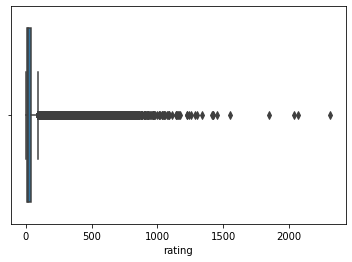

In [ ]:
sns.boxplot(rating_pivot)
plt.show()

In [ ]:
rating_pivot=movie_ratings.groupby('userId')['rating'].mean()
rating_pivot.sort_values(ascending=False).head()

userId
232991    5.0
12250     5.0
204176    5.0
26848     5.0
215167    5.0
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


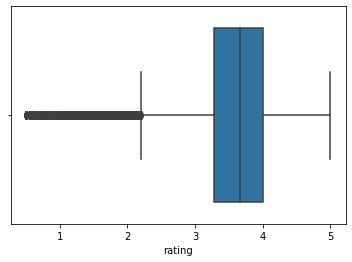

In [ ]:
sns.boxplot(rating_pivot)
plt.show()

There is at least one user who has rated 2,315 movies while there are some users who have only rated 1 movie.

In [ ]:
del rating_pivot

#### 5.2.2.4 Saving the merged data set

In [ ]:
movie_ratings.to_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings.csv')

In [ ]:
del movie_ratings

### 5.2.3 item-item matrix

#### 5.2.3.1 Importing Data

In [ ]:
movie_ratings=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings.csv')

In [ ]:
movie_ratings.shape

(9939845, 4)

In [ ]:
movie_ratings.head()

,Unnamed: 0,userId,rating,title
0,0,1,1.0,Three Colors: Red
1,1,11,3.5,Three Colors: Red
2,2,22,5.0,Three Colors: Red
3,3,24,5.0,Three Colors: Red
4,4,29,3.0,Three Colors: Red


#### 5.2.3.2 Reshaping the data frame

In [ ]:
# dropping the Unnamed:0 column
movie_ratings.drop(columns=['Unnamed: 0'], inplace=True)
movie_ratings.head()

,userId,rating,title
0,1,1.0,Three Colors: Red
1,11,3.5,Three Colors: Red
2,22,5.0,Three Colors: Red
3,24,5.0,Three Colors: Red
4,29,3.0,Three Colors: Red


##### 5.2.3.2.1 Number of Reviews by User

In [ ]:
# calculating the nuber of reviews for each user
reviews_by_user=movie_ratings.groupby('userId')['title'].count()
reviews_by_user.columns=['number_of_reviews']

type(reviews_by_user)

pandas.core.series.Series

In [ ]:
# creating a data frame 
reviews_by_user_df=pd.DataFrame(reviews_by_user)
reviews_by_user_df.columns=['number_of_reviews']
reviews_by_user_df.head()

,number_of_reviews
userId,
1,9
2,17
3,8
4,16
5,10


In [ ]:
# number of users
reviews_by_user_df.shape

(264541, 1)

In [ ]:
# total number of reviews
reviews_by_user_df.number_of_reviews.sum()

9939845

In [ ]:
#determining the number of reviews for a cut off score to reduce the dataset
review_cutoff=reviews_by_user_df.number_of_reviews.quantile(.90)
review_cutoff

94.0

In [ ]:
#determing the number of users that meet the cutoff score
reviews_by_user_df[reviews_by_user_df.number_of_reviews >= review_cutoff].shape

(26666, 1)

In [ ]:
# creating a mask to filter the data
mask=reviews_by_user_df[reviews_by_user_df.number_of_reviews >= review_cutoff].index

In [ ]:
# reindexing by user ratings to apply the mask
movie_ratings.index=movie_ratings.userId
movie_ratings.drop(columns=['userId'], inplace=True)
movie_ratings.head()

,rating,title
userId,,
1,1.0,Three Colors: Red
11,3.5,Three Colors: Red
22,5.0,Three Colors: Red
24,5.0,Three Colors: Red
29,3.0,Three Colors: Red


In [ ]:
# smaller dataset based on filtering out the users
movies_ratings_small=movie_ratings.loc[mask,:]
movies_ratings_small.shape

(5019231, 2)

In [ ]:
movies_ratings_small.head()

,rating,title
userId,,
12,4.0,Sleepless in Seattle
12,5.0,Rocky Balboa
12,3.0,Young and Innocent
12,5.0,The 39 Steps
12,1.0,Parenthood


In [ ]:
# reindex movie_ratins_small
movies_ratings_small.reset_index(inplace=True)

##### 5.2.3.2.2 Number of Reviews by movie

In [ ]:
# calculating the number of reviews by movie
reviews_by_movie=movies_ratings_small.groupby('title')['userId'].count()
reviews_by_movie.head()

title
$5 a Day                                 133
'Twas the Night Before Christmas         328
...And God Created Woman                  23
00 Schneider - Jagd auf Nihil Baxter      60
10 Items or Less                        1422
Name: userId, dtype: int64

In [ ]:
# creating a df from reviews_by_movie
reviews_by_movie_df=pd.DataFrame(reviews_by_movie)
reviews_by_movie_df.columns=['number_of_reviews']

reviews_by_movie_df.head()

,number_of_reviews
title,
$5 a Day,133
'Twas the Night Before Christmas,328
...And God Created Woman,23
00 Schneider - Jagd auf Nihil Baxter,60
10 Items or Less,1422


In [ ]:
# number of movies
reviews_by_movie.shape

(3967,)

In [ ]:
#distribution for the reviews by movie
reviews_by_movie_df.describe()

,number_of_reviews
count,3967.000000
mean,1265.246030
std,2816.014083
min,1.000000
25%,22.000000
50%,135.000000
75%,968.000000
max,24937.000000


In [ ]:
#use the 30th quantile as the cutoff
movie_cutoff=reviews_by_movie_df.number_of_reviews.quantile(0.30)
movie_cutoff

32.0

In [ ]:
# creating a movie mask to filter the data
movie_mask=reviews_by_movie_df[reviews_by_movie_df >=movie_cutoff].index

In [ ]:
# reindex movie_ratings
movies_ratings_small.index=movies_ratings_small.title
movies_ratings_small.head()

,userId,rating,title
title,,,
Sleepless in Seattle,12,4.0,Sleepless in Seattle
Rocky Balboa,12,5.0,Rocky Balboa
Young and Innocent,12,3.0,Young and Innocent
The 39 Steps,12,5.0,The 39 Steps
Parenthood,12,1.0,Parenthood


In [ ]:
#filtering out movies with less than 32 reviews
movie_ratings_small=movies_ratings_small.loc[movie_mask,:]

In [ ]:
# rest index
movie_ratings_small.title=movie_ratings_small.index

movie_ratings_small.reset_index(drop=True, inplace=True)

movie_ratings_small.head()

,userId,rating,title
0,5378,3.0,$5 a Day
1,6201,1.0,$5 a Day
2,8273,3.0,$5 a Day
3,8659,2.5,$5 a Day
4,9444,2.0,$5 a Day


In [ ]:
# number of reviews
movie_ratings_small.shape

(5019231, 3)

In [ ]:
# number of users
movie_ratings_small.groupby('userId')['title'].count().shape

(26666,)

In [ ]:
# number of movies
movie_ratings_small.groupby('title')['userId'].count().shape

(3967,)

##### 5.2.3.2.3 Saving movie_ratings_small

In [ ]:
movie_ratings_small.to_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings_small.csv')

##### 5.2.3.2.4 Creating Item Matrix

In [ ]:
#Importing data
movie_ratings_small=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings_small.csv')

In [ ]:
# creating the user_item matrix
item_user=pd.pivot_table(movie_ratings_small, index='title', columns='userId', values='rating', fill_value=np.nan)

In [ ]:
# checking the size of the matrix
item_user.shape

(3967, 26666)

In [ ]:
#looking at the first few rows
item_user.head()

userId,12,24,43,46,49,62,65,98,120,125,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
title,,,,,,,,,,,,,,,,,,,,,
$5 a Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Twas the Night Before Christmas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And God Created Woman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00 Schneider - Jagd auf Nihil Baxter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Items or Less,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 5.2.3.2.5 Saving user item matrix

In [ ]:
#reset index
item_user.reset_index()

userId,title,12,24,43,46,49,62,65,98,120,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
0,$5 a Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,'Twas the Night Before Christmas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,...And God Created Woman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00 Schneider - Jagd auf Nihil Baxter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10 Items or Less,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,xXx,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,¡Three Amigos!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,À nos amours,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3965,Æon Flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
item_user.to_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/item_user.csv')

##### 5.2.3.2.5 House Cleaning

In [ ]:
del movie_ratings
del mask
del movie_mask
del movie_cutoff
del movies_ratings_small
del reviews_by_user
del reviews_by_user_df
del reviews_by_movie
del reviews_by_movie_df


In [ ]:
del review_cutoff

In [ ]:
del movie_ratings_small

#### 5.2.3.3 dealing with missing value

##### 5.2.3.3.1 Importing Data

In [ ]:
item_user=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/item_user.csv')

In [ ]:
# setting title as index
item_user.index=item_user.title

In [ ]:
#drop title column
item_user.drop(columns=['title'], inplace=True)

In [ ]:
item_user.head()

,12,24,43,46,49,62,65,98,120,125,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
title,,,,,,,,,,,,,,,,,,,,,
$5 a Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Twas the Night Before Christmas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And God Created Woman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00 Schneider - Jagd auf Nihil Baxter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Items or Less,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 5.2.3.3.2 Sparsity

In [ ]:
# finding how many missing ratings
item_user.isna().sum()

12        3837
24        3721
43        3867
46        3701
49        3811
          ... 
270859    3842
270871    3873
270879    3827
270887    3530
270896    3856
Length: 26666, dtype: int64

In [ ]:
#determining the sparsity of the matrix
(item_user.isna().sum().sum())/(item_user.shape[0]*item_user.shape[1])

0.9527795889628776

##### 5.2.3.3.3 Filling NAN with 0

In [ ]:
item_user.fillna(0, inplace=True)

In [ ]:
item_user.head()

,12,24,43,46,49,62,65,98,120,125,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
title,,,,,,,,,,,,,,,,,,,,,
$5 a Day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Twas the Night Before Christmas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And God Created Woman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00 Schneider - Jagd auf Nihil Baxter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Items or Less,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5.2.3.4 Saving item_user Matrix

In [ ]:
# removing the index before saving
item_user.reset_index(inplace=True)

In [ ]:
item_user.to_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/item_user.csv')

#### 5.2.3.5 EDA

##### 5.2.3.5.1 Importing data

In [ ]:
item_user=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/item_user.csv')

In [ ]:
# setting the index
item_user.index=item_user.title

In [ ]:
# drop title column
item_user.drop(columns=['title'], inplace=True)

##### 5.2.3.5.2 Basic Information

In [ ]:
item_user.shape

(3967, 26667)

In [ ]:
item_user.head()

,Unnamed: 0,12,24,43,46,49,62,65,98,120,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
title,,,,,,,,,,,,,,,,,,,,,
$5 a Day,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Twas the Night Before Christmas,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And God Created Woman,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00 Schneider - Jagd auf Nihil Baxter,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Items or Less,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 5.2.3.5.3 Number of Reviews by Title

In [ ]:
item_user.columns

Index(['Unnamed: 0', '12', '24', '43', '46', '49', '62', '65', '98', '120',
       ...
       '270793', '270807', '270828', '270850', '270857', '270859', '270871',
       '270879', '270887', '270896'],
      dtype='object', length=26667)

In [ ]:
df=item_user.reset_index()

In [ ]:
# checking column names
df.columns

Index(['title', 'Unnamed: 0', '12', '24', '43', '46', '49', '62', '65', '98',
       ...
       '270793', '270807', '270828', '270850', '270857', '270859', '270871',
       '270879', '270887', '270896'],
      dtype='object', length=26668)

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,title,12,24,43,46,49,62,65,98,120,...,270793,270807,270828,270850,270857,270859,270871,270879,270887,270896
0,$5 a Day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Twas the Night Before Christmas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,...And God Created Woman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00 Schneider - Jagd auf Nihil Baxter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10 Items or Less,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def rating_count(row):
  count1=0
  for item in row:
    if item ==0:
      count1 += 0
    else: count1 += 1
  return count1

In [ ]:
df['number_reviews']=df.apply(lambda row: rating_count(row), axis=1)

In [ ]:
num_ratings=df.loc[:,['title', 'number_reviews']]
num_ratings.head()

,title,number_reviews
0,$5 a Day,134
1,'Twas the Night Before Christmas,329
2,...And God Created Woman,24
3,00 Schneider - Jagd auf Nihil Baxter,61
4,10 Items or Less,1423


In [ ]:
del df

##### 5.2.3.5.3 Median Rating by Title

In [ ]:
# replace 0's with NAN and calculate median
item_median=item_user.drop(columns=['Unnamed: 0']).replace({0:np.nan}).median(axis=1, skipna=True)

In [ ]:
# movies sorted by rating
item_median=item_median.sort_values(ascending=False)
item_median.iloc[:19]

title
Any Day Now                           5.0
Marfa Girl                            5.0
Phil Spector                          5.0
Möbius                                5.0
Brannigan                             5.0
Mystery                               5.0
Christmas with Holly                  5.0
Murder She Said                       4.5
Labor Day                             4.5
30 Minutes or Less                    4.5
Love & Air Sex                        4.5
The Good Thief                        4.5
Holy Motors                           4.5
Once Were Warriors                    4.5
Terminator 3: Rise of the Machines    4.5
5 Card Stud                           4.5
The Cave of the Golden Rose           4.5
Birth of the Living Dead              4.5
Dread                                 4.5
dtype: float64

In [ ]:
# distribution of median movie ratings.
item_median.describe()

count    3967.000000
mean        3.191581
std         0.651262
min         0.500000
25%         3.000000
50%         3.000000
75%         3.500000
max         5.000000
dtype: float64

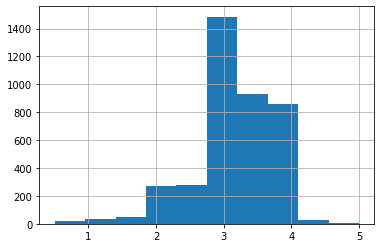

In [ ]:
item_median.hist()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


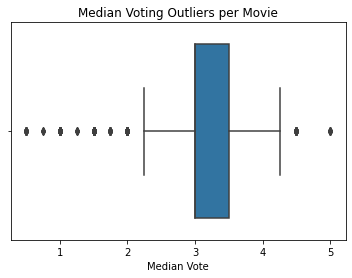

In [ ]:
sns.boxplot(item_median)
plt.xlabel('Median Vote')
plt.title('Median Voting Outliers per Movie')
plt.show()

##### 5.2.3.5.4 Outlier Analysis

Before we can analyze the outliers, we need to put the data into a data frame. Next, we will use the outlier detection function to find the cutoff scores. After finding the cutoff scores, we use them to seperate the data into outlier and non-outliers.

In [ ]:
# converting to dataframe
item_median_df=pd.DataFrame(item_median, columns=['median'])

In [ ]:
del item_median

In [ ]:
# calculating lower and upper bounds
lower, upper=outlier_detect('median', item_median_df)

lower, upper

(2.25, 4.25)

In [ ]:
# creating an outlier column
item_median_df['outlier']=item_median_df['median'].apply(lambda row: 'outlier' if (row < lower or row > upper) else 'non-outlier')

In [ ]:
del lower, upper

In [ ]:
# inspecting first few rows
item_median_df.head()

,median,outlier
title,,
Any Day Now,5.0,outlier
Marfa Girl,5.0,outlier
Phil Spector,5.0,outlier
Möbius,5.0,outlier
Brannigan,5.0,outlier


In [ ]:
# determining number of outliers
item_median_df.groupby('outlier')['median'].count()

outlier
non-outlier    3589
outlier         378
Name: median, dtype: int64

In [ ]:
# combining movie rating median with number of reviews
ratings=num_ratings.merge(item_median_df, how='left', left_on='title', right_index=True)
ratings.head()

,title,number_reviews,median,outlier
0,$5 a Day,134,2.0,outlier
1,'Twas the Night Before Christmas,329,4.0,non-outlier
2,...And God Created Woman,24,3.5,non-outlier
3,00 Schneider - Jagd auf Nihil Baxter,61,3.0,non-outlier
4,10 Items or Less,1423,4.0,non-outlier


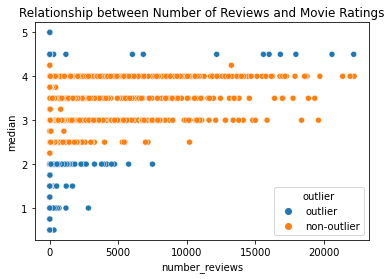

In [ ]:
sns.scatterplot(x=ratings.number_reviews, y=ratings['median'], hue=ratings.outlier)
plt.title('Relationship between Number of Reviews and Movie Ratings')
plt.show()

In [ ]:
ratings.groupby(['outlier','number_reviews'])['median']

#### 5.2.3.6 Cosine Similarity

In [ ]:
item_similarity=cosine_similarity(item_user)

In [ ]:
# saving titles
title=item_user.index

In [ ]:
item_similarity_df=pd.DataFrame(item_similarity, index = title, columns=title)
item_similarity_df.head()

title,$5 a Day,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,12 Dates of Christmas,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,[REC],eXistenZ,xXx,¡Three Amigos!,À nos amours,Æon Flux,Ödipussi
title,,,,,,,,,,,,,,,,,,,,,
$5 a Day,1.000000,0.016962,0.044799,0.034139,0.030251,0.079476,0.079823,0.033360,0.037001,0.000000,...,0.001702,0.000728,0.001020,0.000179,0.002543,0.003914,0.000357,0.002654,0.000305,0.000325
'Twas the Night Before Christmas,0.016962,1.000000,0.047494,0.029484,0.034436,0.054226,0.057255,0.025729,0.019649,0.031816,...,0.015799,0.015274,0.015703,0.014807,0.015588,0.019269,0.014790,0.015785,0.015143,0.015589
...And God Created Woman,0.044799,0.047494,1.000000,0.111743,0.071445,0.029167,0.118659,0.162064,0.051653,0.147898,...,0.115085,0.114379,0.114513,0.112811,0.115991,0.115421,0.112875,0.113095,0.113012,0.113112
00 Schneider - Jagd auf Nihil Baxter,0.034139,0.029484,0.111743,1.000000,0.052429,0.042303,0.061634,0.083782,0.058079,0.149062,...,0.121765,0.121536,0.121621,0.120621,0.121662,0.121952,0.120788,0.122156,0.120847,0.120962
10 Items or Less,0.030251,0.034436,0.071445,0.052429,1.000000,0.077379,0.090766,0.073468,0.111783,0.032928,...,0.033832,0.026610,0.027455,0.025971,0.031761,0.030996,0.025946,0.031694,0.026069,0.026538


#### 5.2.3.7 Finding Similar Movies

In [ ]:
# finding similar movies to Men in Black II
men_in_black_II=similar_movies('Men in Black II', item_similarity_df, 10)

#convert to df
men_in_black_df=pd.DataFrame(men_in_black_II.values, index=men_in_black_II.index, columns=['similarity_score'])
men_in_black_df

,similarity_score
title,
Men in Black II,1.000000
Terminator 3: Rise of the Machines,0.986282
Solaris,0.985025
The Million Dollar Hotel,0.982009
The 39 Steps,0.981333
Sleepless in Seattle,0.981055
Point Break,0.980631
Sissi,0.979273
Once Were Warriors,0.979148


In [ ]:
men_in_black_df.merge(item_median_df, how='left', on='title')

,similarity_score,median,outlier
title,,,
Men in Black II,1.000000,4.0,non-outlier
Terminator 3: Rise of the Machines,0.986282,4.5,outlier
Solaris,0.985025,4.0,non-outlier
The Million Dollar Hotel,0.982009,4.5,outlier
The 39 Steps,0.981333,4.0,non-outlier
Sleepless in Seattle,0.981055,4.5,outlier
Point Break,0.980631,4.0,non-outlier
Sissi,0.979273,4.0,non-outlier
Once Were Warriors,0.979148,4.5,outlier


In [ ]:
item_median_df.loc['Sleepless in Seattle',: ]

median         4.0
outlier    outlier
Name: Sleepless in Seattle, dtype: object

In [ ]:
similar_movies('Dawn of the Dead', item_similarity_df, 20)

title
Dawn of the Dead                      1.000000
Men in Black II                       0.918371
Murder She Said                       0.911050
Monsoon Wedding                       0.908582
The 39 Steps                          0.908432
Terminator 3: Rise of the Machines    0.907000
Solaris                               0.906956
Sleepless in Seattle                  0.906946
Once Were Warriors                    0.905450
Cool Hand Luke                        0.905257
License to Wed                        0.903392
Point Break                           0.900023
Jacob's Ladder                        0.898390
Fever Pitch                           0.897525
Lonely Hearts                         0.897181
Mothra vs. Godzilla                   0.896789
Say Anything...                       0.895551
Rope                                  0.895383
The Man with the Golden Arm           0.895168
Fools Rush In                         0.895051
Name: Dawn of the Dead, dtype: float64

### 5.2.4 item_item Filtering Summary

Due to computational power limitations, I will reduce my data set by removing the users with the smallest number of ratings; thus, I need to determine the number of reviews each person has made. I know from trial error that I need to reduce the data set by 90 percent, which is equal to 94 reviews; therefore, user must have reviewed at least 94 movies to be selected. Removing user with fewer than 94 reviews reduced the number of users from 264,541 to 26,666. Additionally, I filtered out all movies with fewer than 32 reviews. I chose 32 as the cutoff because 30% of movies had 32 or fewer reviews. After filtering the data by number of reviews for both users and movies, the data has 26,666 users rating 3,967 movies for a total of 5,019,231 ratings.
By reducing the dataset, we lost the Toy Story movies, which means we cannot directly compare the previous results with collaborative filtering results. 